In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import dotenv
# setup environment variables 
config = dotenv.dotenv_values("../.env")

In [ ]:
# Fish Parameters
bodyLength = 0.982 # meters
mass = 14.755 # kg

# Reading in data

In [3]:
dataDir = config["DATADIR"] + "processed/csvs/20250220/"
# read in file names from dataDir
files = os.listdir(dataDir)

In [4]:
# Initialize an empty list to store DataFrames
dataframes = []
# Loop through the files and read them into DataFrames
for file in files:
    print(file)
    # Extract trial parameters from the file name (assuming a specific naming convention)
    # Example: "trial_param1_param2.txt"
    params = file.replace('.txt', '').split('_')
    # for params[1:6] convert any p's to .'s and convert to floats
    params = [float(param.replace('p', '.')) if (i > 0 and i < 7) else param for i, param in enumerate(params)]    
    # parse parameters in order of "testType","ampFront", "freq", "biasFront", "ampBack", "biasBack", "phi", "trialNumber"
    testType, ampFront, freq, biasFront, ampBack, biasBack, phi, trialNumber = params
    trialName = file.replace('.txt', '')    
    # remove the text "Trial" from trialNumber and convert to int
    trialNumber = int(trialNumber.replace('Trial', ''))
    # Read the timeseries data from the file into a DataFrame with the correct column names
    df = pd.read_csv(dataDir + file, sep=',', header=None)
    df.columns = ['time', 'x_marker1','y_marker1','xpixel_marker1','ypixel_marker1','x_marker2','y_marker2','xpixel_marker2','ypixel_marker2']    
    # Add the trial parameters as columns in the DataFrame
    df['testType'] = testType
    df['ampFront'] = ampFront*360.0 # deg
    df['freq'] = freq
    df['biasFront'] = biasFront*360.0 # deg
    df['ampBack'] = ampBack*360.0 # deg
    df['biasBack'] = biasBack*360.0 # deg
    df['phi'] = phi
    df['trialNumber'] = trialNumber
    df['trialName'] = trialName

    # Append the DataFrame to the list
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(dataframes, ignore_index=True)
# Get rid of any rows that have NaN values
all_data = all_data.dropna()
# Reorder columns for readability
all_data = all_data[['trialName', 'testType', 'ampFront', 'freq', 'biasFront', 'ampBack', 'biasBack', 'phi','trialNumber', 'time', 'x_marker1','y_marker1','xpixel_marker1','ypixel_marker1','x_marker2','y_marker2','xpixel_marker2','ypixel_marker2']]


ForwardPreTest_0p15_3_0_0_0_0_Trial1.txt
ForwardPreTest_0p15_3_0_0_0_0_Trial2.txt
ForwardPreTest_0p15_3_0_0_0_0_Trial3.txt
ForwardPreTest_0p1_3_0_0_0_0_Trial1.txt
ForwardPreTest_0p1_3_0_0_0_0_Trial2.txt
ForwardPreTest_0p1_3_0_0_0_0_Trial3.txt
ForwardPreTest_0p1_5_0_0_0_0_Trial1.txt
ForwardPreTest_0p1_5_0_0_0_0_Trial2.txt
ForwardPreTest_0p1_5_0_0_0_0_Trial3.txt
TurningPreTest_0p0833_3_0p0833_0p0833_0p0833_0_Trial1 .txt
TurningPreTest_0p0833_3_0p0833_0p0833_0p0833_0_Trial2 .txt
TurningPreTest_0p0833_3_0p0833_0p0833_0p0833_0_Trial3 .txt


In [5]:
# Compute Velocities and Accelerations
bodyLength = 0.982 # meters
# Initialize an empty list to store updated DataFrames
updated_dataframes = []

# For every Trial with a unique trialName, compute COM positions, velocities, and accelerations, and add them to the DataFrame
for trialName in all_data['trialName'].unique():
    print(trialName)
    # Get the rows that correspond to the current trial and order by time
    trial_data = all_data[all_data['trialName'] == trialName].sort_values('time')
    # Smooth out marker position data
    trial_data['x_marker1'] = trial_data['x_marker1'].rolling(window=10, min_periods=1).mean()
    trial_data['y_marker1'] = trial_data['y_marker1'].rolling(window=10, min_periods=1).mean()
    trial_data['xpixel_marker1'] = trial_data['xpixel_marker1'].rolling(window=10, min_periods=1).mean()
    trial_data['ypixel_marker1'] = trial_data['ypixel_marker1'].rolling(window=10, min_periods=1).mean()
    trial_data['x_marker2'] = trial_data['x_marker2'].rolling(window=10, min_periods=1).mean()
    trial_data['y_marker2'] = trial_data['y_marker2'].rolling(window=10, min_periods=1).mean()
    trial_data['xpixel_marker2'] = trial_data['xpixel_marker2'].rolling(window=10, min_periods=1).mean()
    trial_data['ypixel_marker2'] = trial_data['ypixel_marker2'].rolling(window=10, min_periods=1).mean()
    # Compute the center of mass positions, 
    trial_data['COM_x'] = 0.5 * (trial_data['x_marker1'] + trial_data['x_marker2'])
    trial_data['COM_y'] = 0.5 * (trial_data['y_marker1'] + trial_data['y_marker2'])
    trial_data['COM_xpixel'] = 0.5 * (trial_data['xpixel_marker1'] + trial_data['xpixel_marker2'])
    trial_data['COM_ypixel'] = 0.5 * (trial_data['ypixel_marker1'] + trial_data['ypixel_marker2'])
    trial_data['theta'] = np.arctan2(trial_data['y_marker1'] - trial_data['y_marker2'], trial_data['x_marker1'] - trial_data['x_marker2'])
    # Detect when theta jumps by pi and correct it
    trial_data['theta'] = np.unwrap(trial_data['theta'])
    # Convert angles to degrees
    trial_data['theta'] = np.rad2deg(trial_data['theta'])
    # # Smooth out COM position and theta data
    # trial_data['COM_x'] = trial_data['COM_x'].rolling(window=10, min_periods=1).mean()
    # trial_data['COM_y'] = trial_data['COM_y'].rolling(window=10, min_periods=1).mean()
    # trial_data['COM_xpixel'] = trial_data['COM_xpixel'].rolling(window=10, min_periods=1).mean()
    # trial_data['COM_ypixel'] = trial_data['COM_ypixel'].rolling(window=10, min_periods=1).mean()
    # trial_data['theta'] = trial_data['theta'].rolling(window=10, min_periods=1).mean()
    # Compute the velocities and accelerations
    trial_data['COM_vx'] = trial_data['COM_x'].diff() / trial_data['time'].diff()
    trial_data['COM_vy'] = trial_data['COM_y'].diff() / trial_data['time'].diff()
    trial_data['COM_v'] = np.sqrt(trial_data['COM_vx']**2 + trial_data['COM_vy']**2)
    trial_data['COM_v_bl'] = trial_data['COM_v']/bodyLength # body lengths per second
    trial_data['thetadot'] = trial_data['theta'].diff() / trial_data['time'].diff()
    trial_data['COM_ax'] = trial_data['COM_vx'].diff() / trial_data['time'].diff()
    trial_data['COM_ay'] = trial_data['COM_vy'].diff() / trial_data['time'].diff()
    trial_data['COM_a'] = np.sqrt(trial_data['COM_ax']**2 + trial_data['COM_ay']**2)
    trial_data['thetaddot'] = trial_data['thetadot'].diff() / trial_data['time'].diff()
    # # Smooth out COM velocity and acceleration data 
    # trial_data['COM_vx'] = trial_data['COM_vx'].rolling(window=5, min_periods=1).mean()
    # trial_data['COM_vy'] = trial_data['COM_vy'].rolling(window=5, min_periods=1).mean()
    # trial_data['COM_v'] = trial_data['COM_v'].rolling(window=5, min_periods=1).mean()
    # trial_data['thetadot'] = trial_data['thetadot'].rolling(window=5, min_periods=1).mean()
    # trial_data['COM_ax'] = trial_data['COM_ax'].rolling(window=5, min_periods=1).mean()
    # trial_data['COM_ay'] = trial_data['COM_ay'].rolling(window=5, min_periods=1).mean()
    # trial_data['COM_a'] = trial_data['COM_a'].rolling(window=5, min_periods=1).mean()
    # trial_data['thetaddot'] = trial_data['thetaddot'].rolling(window=5, min_periods=1).mean()

    # Append the updated trial_data to the list
    updated_dataframes.append(trial_data)

# Concatenate all updated DataFrames into a single DataFrame
all_data = pd.concat(updated_dataframes, ignore_index=True)

ForwardPreTest_0p15_3_0_0_0_0_Trial1
ForwardPreTest_0p15_3_0_0_0_0_Trial2
ForwardPreTest_0p15_3_0_0_0_0_Trial3
ForwardPreTest_0p1_3_0_0_0_0_Trial1
ForwardPreTest_0p1_3_0_0_0_0_Trial2
ForwardPreTest_0p1_3_0_0_0_0_Trial3
ForwardPreTest_0p1_5_0_0_0_0_Trial1
ForwardPreTest_0p1_5_0_0_0_0_Trial2
ForwardPreTest_0p1_5_0_0_0_0_Trial3
TurningPreTest_0p0833_3_0p0833_0p0833_0p0833_0_Trial1 
TurningPreTest_0p0833_3_0p0833_0p0833_0p0833_0_Trial2 
TurningPreTest_0p0833_3_0p0833_0p0833_0p0833_0_Trial3 


In [6]:
# Filter all velocity data to smooth out noise


# Computing statistics and generating visualizations

C:\Users\imana\AppData\Local\Temp\ipykernel_37200\524701969.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


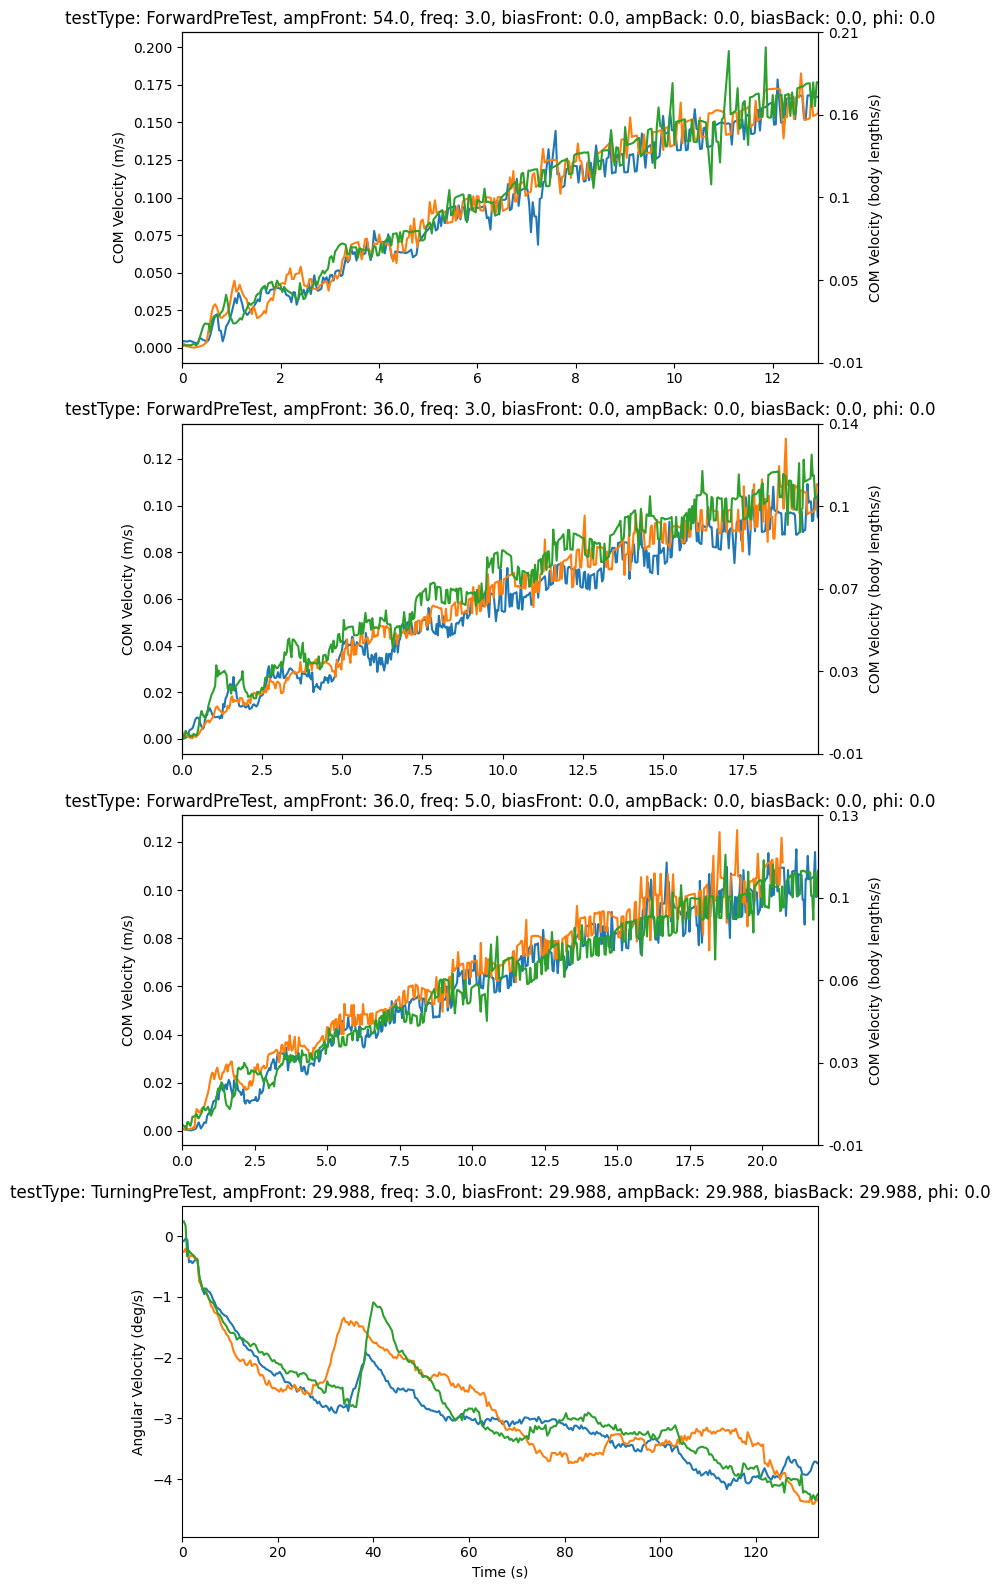

In [7]:
# Get how many unique sets of parameters there are
unique_params = all_data[['testType', 'ampFront', 'freq', 'biasFront', 'ampBack', 'biasBack', 'phi']].drop_duplicates()
# Generate figure with a subplot for each unique set of parameters
fig, axs = plt.subplots(len(unique_params), 1, figsize=(8, 4*len(unique_params)), sharex=False)

# For each unique set of parameters, plot the center of mass velocity over time for all present trials on the same subplot
for i, params in enumerate(unique_params.iterrows()):
    params = params[1]
    # Get the rows that correspond to the current set of parameters
    params_data = all_data[(all_data['testType'] == params['testType']) & 
                            (all_data['ampFront'] == params['ampFront']) & 
                            (all_data['freq'] == params['freq']) & 
                            (all_data['biasFront'] == params['biasFront']) & 
                            (all_data['ampBack'] == params['ampBack']) & 
                            (all_data['biasBack'] == params['biasBack']) & 
                            (all_data['phi'] == params['phi'])]
    # Plot the center of mass velocity over time for all present trials, except for the last subplot
    if i < len(unique_params) - 1:
        for trialName in params_data['trialName'].unique():
            trial_data = params_data[params_data['trialName'] == trialName]
            trial_data = trial_data.iloc[:-15]  # Remove the last 5 timesteps
            axs[i].plot(trial_data['time'], trial_data['COM_v'], label=trialName)
        axs[i].set_ylabel('COM Velocity (m/s)')
        
        # Create a secondary y-axis to show body lengths per second velocities
        ax2 = axs[i].twinx()
        ax2.set_ylabel('COM Velocity (body lengths/s)')
        ax2.set_ylim(axs[i].get_ylim())
        ax2.set_yticks(np.linspace(axs[i].get_ylim()[0], axs[i].get_ylim()[1], 5))
        ax2.set_yticklabels(np.round(np.linspace(axs[i].get_ylim()[0] / bodyLength, axs[i].get_ylim()[1] / bodyLength, 5), 2))
    else:
        # Plot the angular velocity (thetadot) for the last subplot
        for trialName in params_data['trialName'].unique():
            trial_data = params_data[params_data['trialName'] == trialName]
            trial_data = trial_data.iloc[:-5]  # Remove the last 5 timesteps
            axs[i].plot(trial_data['time'], trial_data['thetadot'], label=trialName)
        axs[i].set_ylabel('Angular Velocity (deg/s)')
    
    # Add labels and title to the subplot
    axs[i].set_title(f"testType: {params['testType']}, ampFront: {params['ampFront']}, freq: {params['freq']}, biasFront: {params['biasFront']}, ampBack: {params['ampBack']}, biasBack: {params['biasBack']}, phi: {params['phi']}")
    axs[i].set_xlim([trial_data['time'].min(), trial_data['time'].max() - 5 * (trial_data['time'].diff().mean())])  # Zoom x-axis to where there's data

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('Time (s)')
fig.tight_layout()
fig.show()
# Save the figure as svg
fig.savefig('COM_velocities.svg')

In [8]:
# #  For each unique set of parameters with testType==ForwardPretest, compute the average and standard deviation of acceleration over the first 10 seconds for all present trials
# forward_test_params = unique_params[unique_params['testType'] == 'ForwardPreTest']
# forward_test_avg_accel = []
# forward_test_std_accel = []
# forward_test_std_error = []

# for i, params in forward_test_params.iterrows():
#     # Get the rows that correspond to the current set of parameters
#     params_data = all_data[(all_data['testType'] == params['testType']) & 
#                             (all_data['ampFront'] == params['ampFront']) & 
#                             (all_data['freq'] == params['freq']) & 
#                             (all_data['biasFront'] == params['biasFront']) & 
#                             (all_data['ampBack'] == params['ampBack']) & 
#                             (all_data['biasBack'] == params['biasBack']) & 
#                             (all_data['phi'] == params['phi'])]
#     # Compute the average and standard deviation of acceleration over the first 10 seconds for all present trials
#     avg_accel = []
#     std_accel = []
#     for trialName in params_data['trialName'].unique():
#         trial_data = params_data[params_data['trialName'] == trialName]
#         accel_data = trial_data[trial_data['time'] <= 10]['COM_a']
#         avg_accel.append(accel_data.mean())
#         std_accel.append(accel_data.std())
#     forward_test_avg_accel.append(np.mean(avg_accel))
#     forward_test_std_accel.append(np.mean(std_accel))
#     forward_test_std_error.append(np.std(std_accel)/np.sqrt(len(std_accel)))
    

In [9]:
#  For each unique set of parameters with testType==ForwardPretest, compute the average acceleration over the first 10 seconds for each present trials and put in a new DataFrame
forward_test_params = unique_params[unique_params['testType'] == 'ForwardPreTest']
forward_test_avg_accel = []
forward_test_std_accel = []
forward_test_std_error = []
forward_test_trialName = []
forward_test_ampFront = []
forward_test_freq = []
forward_test_biasFront = []
forward_test_ampBack = []
forward_test_biasBack = []
forward_test_phi = []

for i, params in forward_test_params.iterrows():
    # Get the rows that correspond to the current set of parameters
    params_data = all_data[(all_data['testType'] == params['testType']) & 
                            (all_data['ampFront'] == params['ampFront']) & 
                            (all_data['freq'] == params['freq']) & 
                            (all_data['biasFront'] == params['biasFront']) & 
                            (all_data['ampBack'] == params['ampBack']) & 
                            (all_data['biasBack'] == params['biasBack']) & 
                            (all_data['phi'] == params['phi'])]
    # Compute the average and standard deviation of acceleration over the first 10 seconds for all present trials
    avg_accel = []
    std_accel = []
    for trialName in params_data['trialName'].unique():
        trial_data = params_data[params_data['trialName'] == trialName]
        accel_data = trial_data[trial_data['time'] <= 10]['COM_a']
        avg_accel.append(accel_data.mean())
        std_accel.append(accel_data.std())
        forward_test_trialName.append(trialName)
        forward_test_ampFront.append(params['ampFront'])
        forward_test_freq.append(params['freq'])
        forward_test_biasFront.append(params['biasFront'])
        forward_test_ampBack.append(params['ampBack'])
        forward_test_biasBack.append(params['biasBack'])
        forward_test_phi.append(params['phi'])
    forward_test_avg_accel.extend(avg_accel)
    forward_test_std_accel.extend(std_accel)
# Create a new DataFrame with the average acceleration for each trial
forward_test_avg_accel_df = pd.DataFrame({'trialName': forward_test_trialName, 'ampFront': forward_test_ampFront, 'freq': forward_test_freq, 'biasFront': forward_test_biasFront, 'ampBack': forward_test_ampBack, 'biasBack': forward_test_biasBack, 'phi': forward_test_phi, 'avg_accel': forward_test_avg_accel, 'std_accel': forward_test_std_accel})
forward_test_avg_accel_df


,trialName,ampFront,freq,biasFront,ampBack,biasBack,phi,avg_accel,std_accel
0,ForwardPreTest_0p15_3_0_0_0_0_Trial1,54.0,3.0,0.0,0.0,0.0,0.0,0.166682,0.147989
1,ForwardPreTest_0p15_3_0_0_0_0_Trial2,54.0,3.0,0.0,0.0,0.0,0.0,0.147624,0.127949
2,ForwardPreTest_0p15_3_0_0_0_0_Trial3,54.0,3.0,0.0,0.0,0.0,0.0,0.137029,0.129803
3,ForwardPreTest_0p1_3_0_0_0_0_Trial1,36.0,3.0,0.0,0.0,0.0,0.0,0.084500,0.073693
4,ForwardPreTest_0p1_3_0_0_0_0_Trial2,36.0,3.0,0.0,0.0,0.0,0.0,0.076097,0.070852
5,ForwardPreTest_0p1_3_0_0_0_0_Trial3,36.0,3.0,0.0,0.0,0.0,0.0,0.086595,0.069345
6,ForwardPreTest_0p1_5_0_0_0_0_Trial1,36.0,5.0,0.0,0.0,0.0,0.0,0.072321,0.054436
7,ForwardPreTest_0p1_5_0_0_0_0_Trial2,36.0,5.0,0.0,0.0,0.0,0.0,0.084129,0.065787
8,ForwardPreTest_0p1_5_0_0_0_0_Trial3,36.0,5.0,0.0,0.0,0.0,0.0,0.070525,0.052548


In [10]:
# Compute average of average accelerations for each unique set of parameters
avg_accels = forward_test_avg_accel_df.groupby(['ampFront', 'freq', 'biasFront', 'ampBack', 'biasBack', 'phi'])['avg_accel'].mean()
# Compute standard deviation of average accelerations for each unique set of parameters
std_accels = forward_test_avg_accel_df.groupby(['ampFront', 'freq', 'biasFront', 'ampBack', 'biasBack', 'phi'])['avg_accel'].std()
# Compute standard error of average accelerations for each unique set of parameters
std_errors = forward_test_avg_accel_df.groupby(['ampFront', 'freq', 'biasFront', 'ampBack', 'biasBack', 'phi'])['avg_accel'].std()/np.sqrt(forward_test_avg_accel_df.groupby(['ampFront', 'freq', 'biasFront', 'ampBack', 'biasBack', 'phi'])['avg_accel'].count())

# Put in numpy arrays
avg_accels = avg_accels.to_numpy()
std_accels = std_accels.to_numpy()
std_errors = std_errors.to_numpy()
# Print results
print('Average Accelerations:')
print(avg_accels)
print('Standard Deviations:')
print(std_accels)
print('Standard Errors:')
print(std_errors)


Average Accelerations:
[0.08239722 0.07565861 0.15044492]
Standard Deviations:
[0.00555604 0.00739062 0.01502605]
Standard Errors:
[0.00320778 0.00426697 0.00867529]


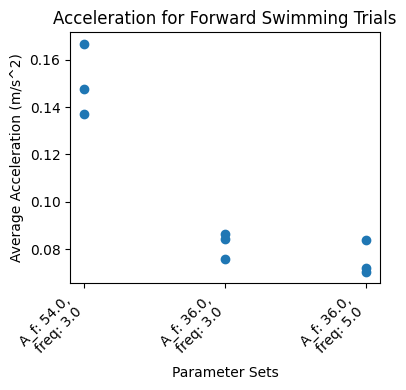

In [11]:
# Make a categorical scatter plot with x-axis corresponding to unique sets of ampFront and freq parameters and y-axis corresponding to average acceleration
# Generate text categories of unique sets of ampFront and freq parameters
forward_test_avg_accel_df['param_set'] = [f"A_f: {ampFront},\nfreq: {freq}" for ampFront, freq in zip(forward_test_avg_accel_df['ampFront'], forward_test_avg_accel_df['freq'])]
# Create a new figure for the plot
fig, ax = plt.subplots(figsize=(4, 4))
# Plot the average acceleration for each trial
ax.scatter(forward_test_avg_accel_df['param_set'], forward_test_avg_accel_df['avg_accel'])
# Set the x-axis labels to the parameter sets
ax.set_xticks(range(len(forward_test_params)))
ax.set_xticklabels(forward_test_avg_accel_df['param_set'].unique(), rotation=45, ha='right')
# Add labels and title
ax.set_xlabel('Parameter Sets')
ax.set_ylabel('Average Acceleration (m/s^2)')
ax.set_title('Acceleration for Forward Swimming Trials')
# Show the plot
plt.tight_layout()
plt.show()

# Save plot as svg
fig.savefig('forward_acceleration.svg', format='svg', dpi=1200)





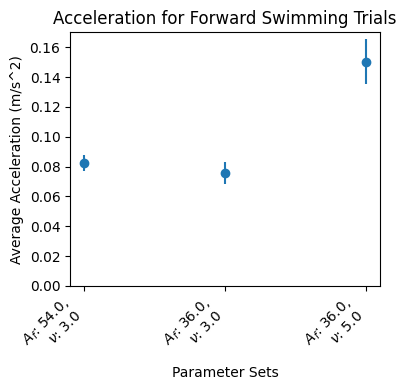

In [12]:

# Make a categorical scatter plot with x-axis corresponding to unique sets of ampFront and freq parameters and y-axis corresponding to average of average acceleration with error bars showing standard deviation of average accelerations
# Generate text categories of unique sets of ampFront and freq parameters
forward_test_avg_accel_df['param_set'] = [f"$A_f$: {ampFront},\n$\\nu$: {freq}" for ampFront, freq in zip(forward_test_avg_accel_df['ampFront'], forward_test_avg_accel_df['freq'])]
# Create a new figure for the plot
fig, ax = plt.subplots(figsize=(4, 4))
# Plot average of average accelerations with standard deviation error bars
ax.errorbar(range(len(forward_test_params)), avg_accels, yerr=std_accels, fmt='o')
# Set the x-axis labels to the parameter sets
ax.set_xticks(range(len(forward_test_params)))
ax.set_xticklabels(forward_test_avg_accel_df['param_set'].unique(), rotation=45, ha='right')
# Add labels and title
ax.set_xlabel('Parameter Sets')
ax.set_ylabel('Average Acceleration (m/s^2)')
ax.set_title('Acceleration for Forward Swimming Trials')
# Set y axis limits
ax.set_ylim([0, 0.17])
# Show the plot
plt.tight_layout()
plt.show()

# Save plot as svg
fig.savefig('forward_acceleration_with_errorbars.svg', format='svg', dpi=1200)

In [13]:
# Compute average thetadot and average thetaddot for every trial of type TurningPreTest with unique parameters and put in a new DataFrame
# Get unique parameters for TurningPreTest trials
turning_test_params = unique_params[unique_params['testType'] == 'TurningPreTest']
turning_test_avg_thetadot = []
turning_test_avg_thetaddot = []
turning_test_trialName = []
turning_test_ampFront = []
turning_test_freq = []
turning_test_biasFront = []
turning_test_ampBack = []
turning_test_biasBack = []
turning_test_phi = []

for i, params in turning_test_params.iterrows():
    # Get the rows that correspond to the current set of parameters
    params_data = all_data[(all_data['testType'] == params['testType']) & 
                            (all_data['ampFront'] == params['ampFront']) & 
                            (all_data['freq'] == params['freq']) & 
                            (all_data['biasFront'] == params['biasFront']) & 
                            (all_data['ampBack'] == params['ampBack']) & 
                            (all_data['biasBack'] == params['biasBack']) & 
                            (all_data['phi'] == params['phi'])]
    # Compute the average thetadot and thetaddot for all present trials between times 50 and 100
    avg_thetadot = []
    avg_thetaddot = []
    for trialName in params_data['trialName'].unique():
        trial_data = params_data[(params_data['trialName'] == trialName) & (params_data['time'] >= 50) & (params_data['time'] <= 100)]
        thetadot_data = trial_data['thetadot']
        thetaddot_data = trial_data['thetaddot']
        avg_thetadot.append(thetadot_data.mean())
        avg_thetaddot.append(thetaddot_data.mean())
        turning_test_trialName.append(trialName)
        turning_test_ampFront.append(params['ampFront'])
        turning_test_freq.append(params['freq'])
        turning_test_biasFront.append(params['biasFront'])
        turning_test_ampBack.append(params['ampBack'])
        turning_test_biasBack.append(params['biasBack'])
        turning_test_phi.append(params['phi'])
    turning_test_avg_thetadot.extend(avg_thetadot)
    turning_test_avg_thetaddot.extend(avg_thetaddot)
# Create a new DataFrame with the average thetadot and thetaddot for each trial
turning_test_avg_thetadot_df = pd.DataFrame({'trialName': turning_test_trialName, 'ampFront': turning_test_ampFront, 'freq': turning_test_freq, 'biasFront': turning_test_biasFront, 'ampBack': turning_test_ampBack, 'biasBack': turning_test_biasBack, 'phi': turning_test_phi, 'avg_thetadot': turning_test_avg_thetadot, 'avg_thetaddot': turning_test_avg_thetaddot})
turning_test_avg_thetadot_df




,trialName,ampFront,freq,biasFront,ampBack,biasBack,phi,avg_thetadot,avg_thetaddot
0,TurningPreTest_0p0833_3_0p0833_0p0833_0p0833_0...,29.988,3.0,29.988,29.988,29.988,0.0,-3.136412,-0.013468
1,TurningPreTest_0p0833_3_0p0833_0p0833_0p0833_0...,29.988,3.0,29.988,29.988,29.988,0.0,-3.142850,-0.024443
2,TurningPreTest_0p0833_3_0p0833_0p0833_0p0833_0...,29.988,3.0,29.988,29.988,29.988,0.0,-3.068355,-0.020556


In [ ]:
# Compute average and std of avg_thetaddot
avg_thetaddots = turning_test_avg_thetadot_df['avg_thetaddot'].mean()
std_thetaddots = turning_test_avg_thetadot_df['avg_thetaddot'].std()
# Print results 
print('Average thetaddots:')
print(avg_thetaddots)
print('Standard Deviations:')
print(std_thetaddots)


Average thetaddots:
-0.019488635087347717
Standard Deviations:
0.005564755361133756


: 

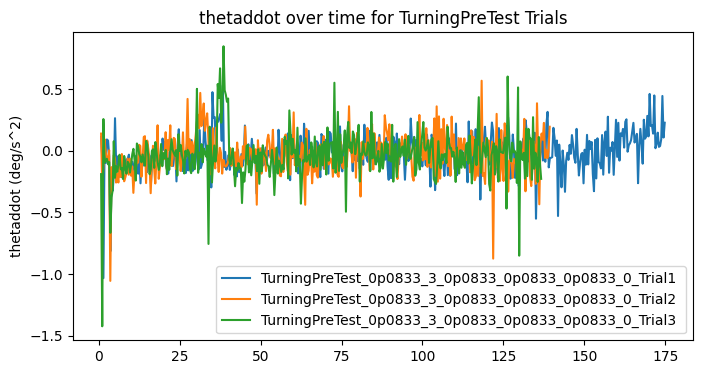

In [15]:
# Plot thetaddot over time for all trials with type==TurningPreTest on the same plot
# Generate figure with a single subplot
fig, ax = plt.subplots(figsize=(8, 4))

# For each unique set of parameters, plot thetadot over time for all present trials
for i, params in enumerate(turning_test_params.iterrows()):
    params = params[1]
    # Get the rows that correspond to the current set of parameters
    params_data = all_data[(all_data['testType'] == params['testType']) & 
                            (all_data['ampFront'] == params['ampFront']) & 
                            (all_data['freq'] == params['freq']) & 
                            (all_data['biasFront'] == params['biasFront']) & 
                            (all_data['ampBack'] == params['ampBack']) & 
                            (all_data['biasBack'] == params['biasBack']) & 
                            (all_data['phi'] == params['phi'])]
    # Plot thetadot over time for all present trials
    for trialName in params_data['trialName'].unique():
        trial_data = params_data[params_data['trialName'] == trialName]
        ax.plot(trial_data['time'], trial_data['thetaddot'], label=trialName)
    # Add labels and title to the subplot
    ax.set_ylabel('thetaddot (deg/s^2)')
    ax.set_title('thetaddot over time for TurningPreTest Trials')
    ax.legend()